Paper title: A bidirectional LSTM deep learning approach for intrusion detection.


In this paper, the drawback of the bidirectional LSTM is that the training period is very large(i.e. 9789 seconds) but this version of bi-LSTM takes only between 40-50 seconds to train.
The dataset used in the paper(nsl-kdd) is very similar to the dataset which is considered here.(41 input features, binary classification, same as the considered dataset).the size of the dataset is about 5 times the dataset considered.As the details of the batch size and other hyperparameters are not mentioned in the paper,the considered model performs better than the model in the paper considering the known constraints.

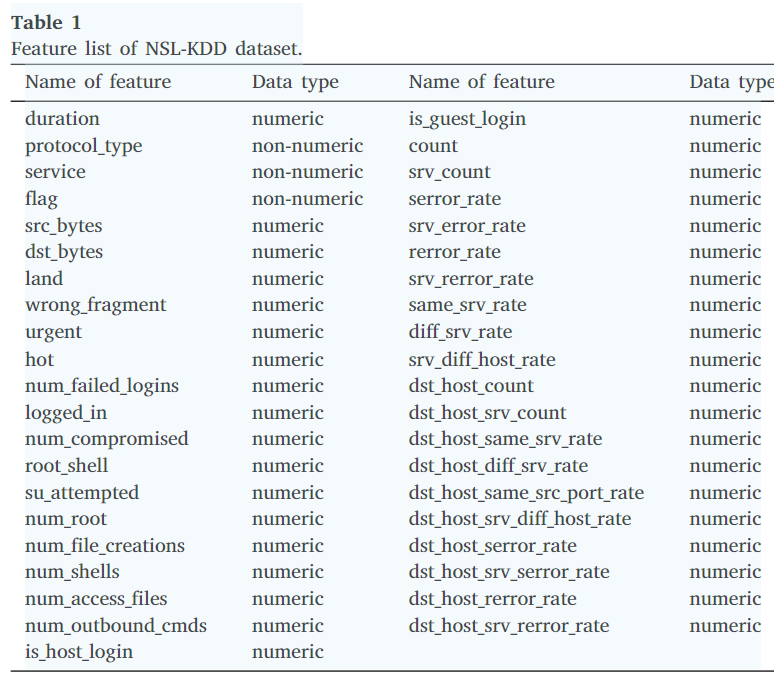

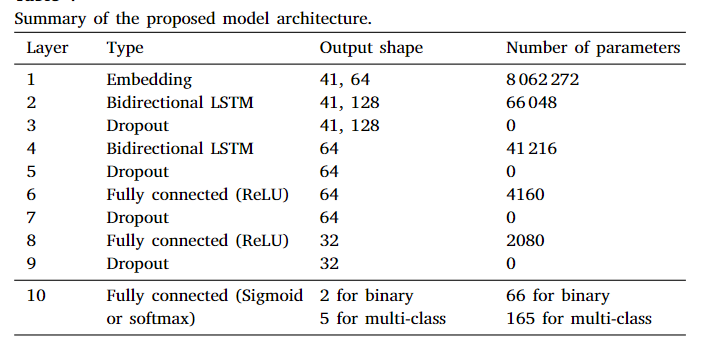

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [ ]:


# Load your CSV file
file_path = 'processed_train.csv'
df = pd.read_csv(file_path)

# Assuming the last column is your target column
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features (optional but often recommended for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM (assuming 1 time step for each feature)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
import time
start = time.time()
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
end = time.time()
# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert predictions to 1D array
y_pred = y_pred.flatten()
training_time = end-start
print(f'Training time:{training_time}')
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


Epoch 1/10
504/504 [==============================] - 14s 10ms/step - loss: 0.1307 - accuracy: 0.9572 - val_loss: 0.0547 - val_accuracy: 0.9725
Epoch 2/10
504/504 [==============================] - 7s 15ms/step - loss: 0.0449 - accuracy: 0.9811 - val_loss: 0.0426 - val_accuracy: 0.9824
Epoch 3/10
504/504 [==============================] - 4s 7ms/step - loss: 0.0347 - accuracy: 0.9872 - val_loss: 0.0366 - val_accuracy: 0.9824
Epoch 4/10
504/504 [==============================] - 3s 7ms/step - loss: 0.0307 - accuracy: 0.9881 - val_loss: 0.0344 - val_accuracy: 0.9846
Epoch 5/10
504/504 [==============================] - 4s 7ms/step - loss: 0.0273 - accuracy: 0.9891 - val_loss: 0.0338 - val_accuracy: 0.9851
Epoch 6/10
504/504 [==============================] - 7s 13ms/step - loss: 0.0243 - accuracy: 0.9906 - val_loss: 0.0319 - val_accuracy: 0.9873
Epoch 7/10
504/504 [==============================] - 4s 7ms/step - loss: 0.0216 - accuracy: 0.9916 - val_loss: 0.0312 - val_accuracy: 0.9913
Ep

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 1, 128)            54272     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1, 128)            0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 96545 (377.13 KB)
Trainable params: 9654

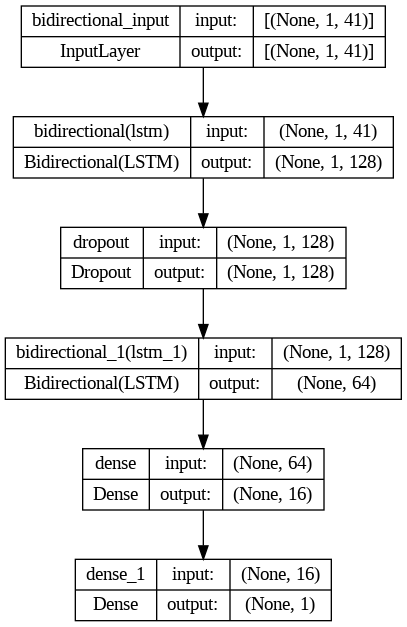

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
far = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f'False Alarm Rate (FAR): {far}')
print(f'Specificity: {specificity}')

False Alarm Rate (FAR): 0.010748065348237317
Specificity: 0.9892519346517626


comparison of both models:
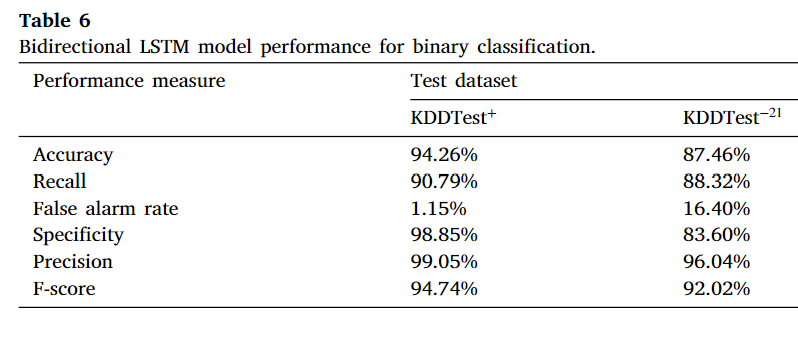

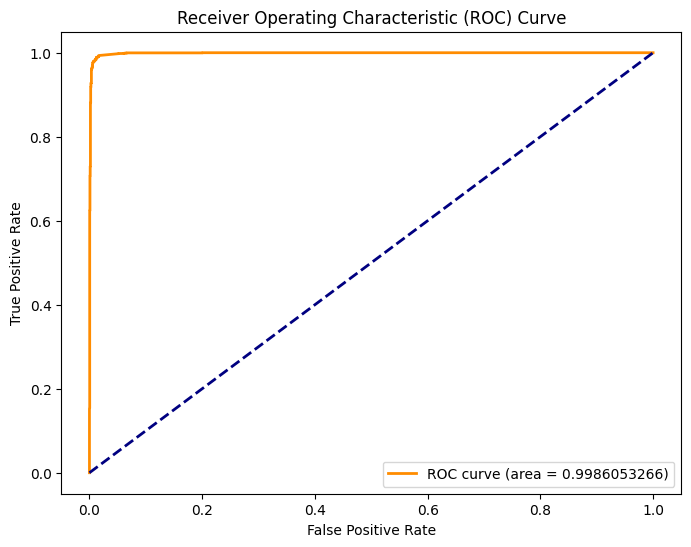

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.10f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Final year project/models/model_bi_lstm_normal.keras')

same model but with data after pca


In [4]:
pip install pandas numpy scikit-learn tensorflow matplotlib seaborn


In [6]:
pip install --upgrade scikit-learn


Epoch 1/10
504/504 [==============================] - 17s 18ms/step - loss: 0.1600 - accuracy: 0.9578 - val_loss: 0.0780 - val_accuracy: 0.9717
Epoch 2/10
504/504 [==============================] - 5s 9ms/step - loss: 0.0681 - accuracy: 0.9733 - val_loss: 0.0536 - val_accuracy: 0.9737
Epoch 3/10
504/504 [==============================] - 5s 9ms/step - loss: 0.0501 - accuracy: 0.9782 - val_loss: 0.0445 - val_accuracy: 0.9851
Epoch 4/10
504/504 [==============================] - 6s 13ms/step - loss: 0.0429 - accuracy: 0.9829 - val_loss: 0.0416 - val_accuracy: 0.9849
Epoch 5/10
504/504 [==============================] - 6s 11ms/step - loss: 0.0395 - accuracy: 0.9851 - val_loss: 0.0417 - val_accuracy: 0.9841
Epoch 6/10
504/504 [==============================] - 4s 9ms/step - loss: 0.0373 - accuracy: 0.9852 - val_loss: 0.0405 - val_accuracy: 0.9841
Epoch 7/10
504/504 [==============================] - 5s 11ms/step - loss: 0.0355 - accuracy: 0.9867 - val_loss: 0.0372 - val_accuracy: 0.9856
E

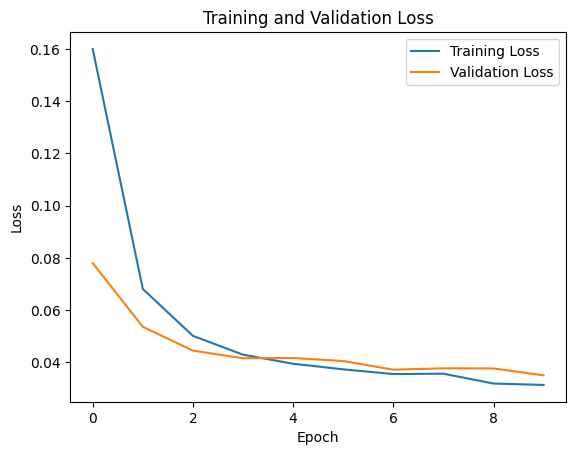

158/158 [==============================] - 3s 5ms/step
Training time: 63.508554220199585
Accuracy: 0.9894820400873189
Recall: 0.989679321784003
Precision: 0.9907749077490775
F1 Score: 0.990226811727826
Confusion Matrix:
[[2301   25]
 [  28 2685]]


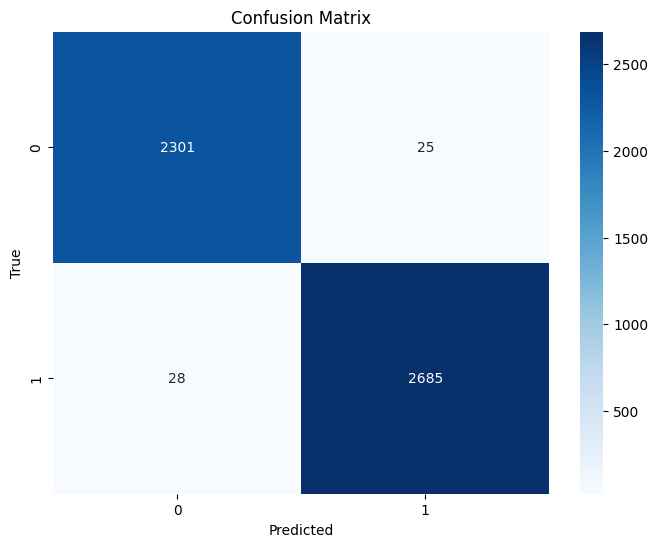

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Load training data
train_file_path = '/content/drive/MyDrive/Final year project/datafinal/train_set_after_pca.csv'
train_df = pd.read_csv(train_file_path)

# Assuming the last column is your target column
X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

# Load testing data
test_file_path = '/content/drive/MyDrive/Final year project/datafinal/test_set_after_pca.csv'
test_df = pd.read_csv(test_file_path)

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Standardize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM (assuming 1 time step for each feature)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
start = time.time()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
end = time.time()

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert predictions to 1D array
y_pred = y_pred.flatten()
training_time = end - start
print(f'Training time: {training_time}')

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



20 times less training time compared to the model in the paper.

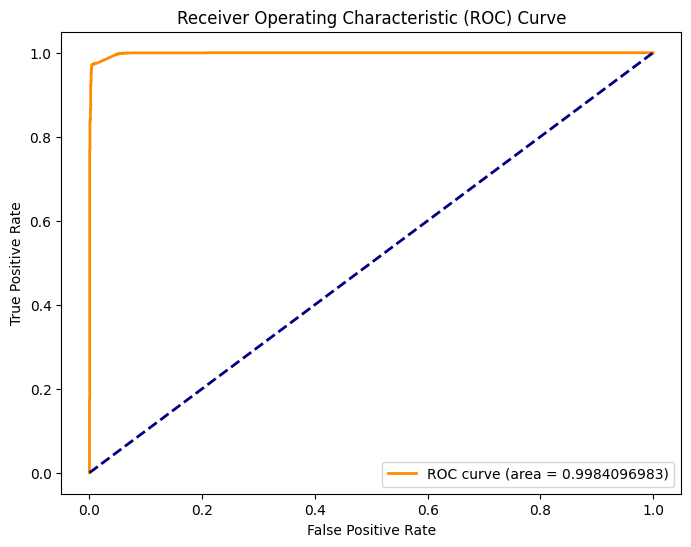

In [ ]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.10f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model1.save('/content/drive/My Drive/Final year project/models/model_bi_lstm_pca.keras')

with lda

In [ ]:
# Load your CSV file
file_path = 'lda_transformed_features.csv'
df = pd.read_csv(file_path)

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Reshape the data for LSTM (assuming 1 time step for each feature)
X = X.reshape((X.shape[0], 1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

import time
start = time.time()

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

end = time.time()
training_time = end - start
print(f'Training time: {training_time}')

# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert predictions to 1D array
y_pred = y_pred.flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


Epoch 1/10
404/404 [==============================] - 16s 17ms/step - loss: 0.1882 - accuracy: 0.9487 - val_loss: 0.1323 - val_accuracy: 0.9547
Epoch 2/10
404/404 [==============================] - 3s 7ms/step - loss: 0.1291 - accuracy: 0.9556 - val_loss: 0.1317 - val_accuracy: 0.9557
Epoch 3/10
404/404 [==============================] - 3s 7ms/step - loss: 0.1283 - accuracy: 0.9556 - val_loss: 0.1311 - val_accuracy: 0.9553
Epoch 4/10
404/404 [==============================] - 3s 8ms/step - loss: 0.1276 - accuracy: 0.9553 - val_loss: 0.1353 - val_accuracy: 0.9547
Epoch 5/10
404/404 [==============================] - 5s 12ms/step - loss: 0.1285 - accuracy: 0.9555 - val_loss: 0.1308 - val_accuracy: 0.9557
Epoch 6/10
404/404 [==============================] - 3s 8ms/step - loss: 0.1277 - accuracy: 0.9553 - val_loss: 0.1311 - val_accuracy: 0.9547
Epoch 7/10
404/404 [==============================] - 3s 8ms/step - loss: 0.1279 - accuracy: 0.9560 - val_loss: 0.1311 - val_accuracy: 0.9560
Epo

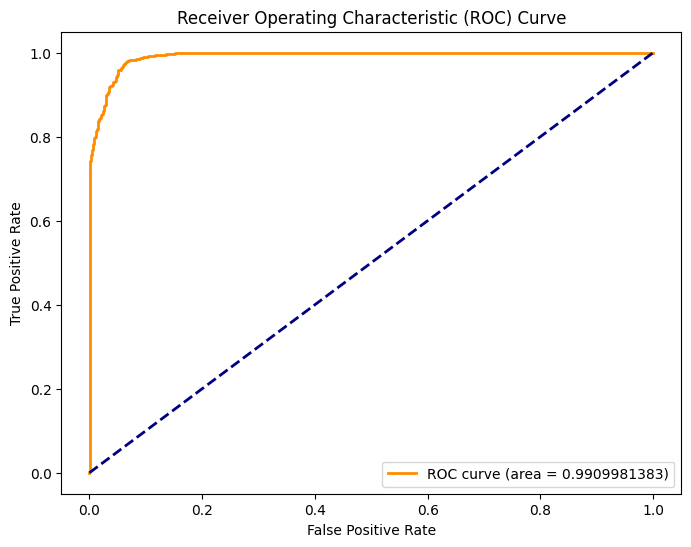

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.10f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Final year project/models/model_bi_lstm_lda.keras')

bidirectional lstm model 2


In [ ]:
# Load your CSV file
file_path = 'processed_train.csv'
df = pd.read_csv(file_path)

# Assuming the last column is your target column
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features (optional but often recommended for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the data for LSTM (assuming 1 time step for each feature)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
from keras.layers import  BatchNormalization
from keras import regularizers

model = Sequential()

# First Bidirectional LSTM layer with return_sequences=True for stacking layers
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Dense layers with regularization
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirect  (None, 41, 128)           33792     
 ional)                                                          
                                                                 
 dropout_6 (Dropout)         (None, 41, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 41, 128)           512       
 Normalization)                                                  
                                                                 
 bidirectional_13 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
start = time.time()
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
end = time.time()
# Evaluate the model on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert predictions to 1D array
y_pred = y_pred.flatten()
time = end-start
print(f'training time:{time}')
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)


Epoch 1/10
504/504 [==============================] - 51s 81ms/step - loss: 1.1013 - accuracy: 0.9253 - val_loss: 0.4047 - val_accuracy: 0.9320
Epoch 2/10
504/504 [==============================] - 42s 83ms/step - loss: 0.2745 - accuracy: 0.9404 - val_loss: 0.2025 - val_accuracy: 0.9521
Epoch 3/10
504/504 [==============================] - 43s 85ms/step - loss: 0.2241 - accuracy: 0.9454 - val_loss: 0.1951 - val_accuracy: 0.9541
Epoch 4/10
504/504 [==============================] - 39s 77ms/step - loss: 0.2129 - accuracy: 0.9466 - val_loss: 0.2063 - val_accuracy: 0.9620
Epoch 5/10
504/504 [==============================] - 41s 82ms/step - loss: 0.2062 - accuracy: 0.9485 - val_loss: 0.1634 - val_accuracy: 0.9608
Epoch 6/10
504/504 [==============================] - 41s 82ms/step - loss: 0.2044 - accuracy: 0.9450 - val_loss: 0.2731 - val_accuracy: 0.9501
Epoch 7/10
504/504 [==============================] - 39s 78ms/step - loss: 0.1937 - accuracy: 0.9491 - val_loss: 0.1515 - val_accuracy:

In [ ]:
far = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f'False Alarm Rate (FAR): {far}')
print(f'Specificity: {specificity}')

False Alarm Rate (FAR): 0.04482029598308668
Specificity: 0.9551797040169133


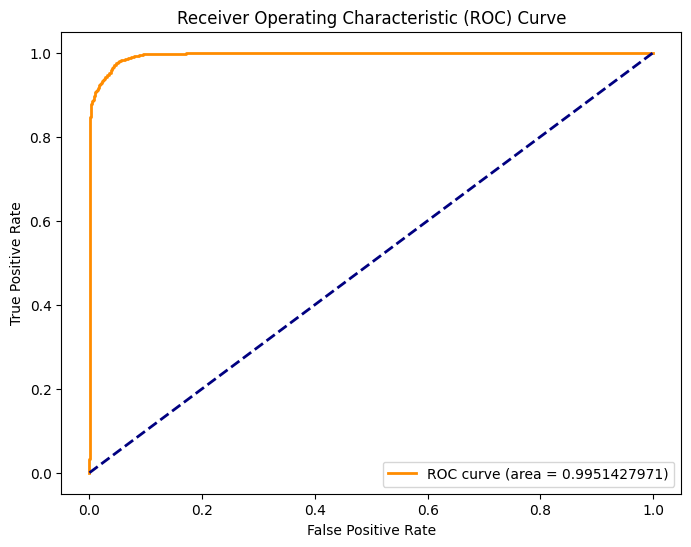

In [ ]:

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.10f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Final year project/models/model_bi_lstm_2.keras')

In [ ]:
train_data = pd.read_csv('train_set_after_pca.csv')
X_train = train_data.iloc[:, :22].values  # Assuming the first 22 columns are features
y_train = train_data.iloc[:, 22].values   # Assuming the last column is the target

# Load your testing data
test_data = pd.read_csv('test_set_after_pca.csv')
X_test = test_data.iloc[:, :22].values    # Assuming the first 22 columns are features
y_test = test_data.iloc[:, 22].values      # Assuming the last column is the target

# Assuming you have already scaled your data or applied any necessary preprocessing

model = Sequential()

# First Bidirectional LSTM layer with return_sequences=True for stacking layers
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01))))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Dense layers with regularization
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
import time
start = time.time()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
end = time.time()
time = end - start
print(f'training period:{time}')


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirect  (None, 22, 128)           33792     
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 22, 128)           0         
                                                                 
 batch_normalization_15 (Ba  (None, 22, 128)           512       
 tchNormalization)                                               
                                                                 
 bidirectional_23 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                     

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert predictions to 1D array
y_pred = y_pred.flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

far = conf_matrix[0, 1] / (conf_matrix[0, 1] + conf_matrix[0, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print(f'False Alarm Rate (FAR): {far}')
print(f'Specificity: {specificity}')

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.10f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Final year project/models/model_bi_pca_2.keras')